In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean, median

from gensim.models import Word2Vec

## Загружаем данные

In [2]:
data = pd.read_csv('data.csv')
data.head(2)

/Users/nadejdaberzina/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00"
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00"


In [3]:
data.rename(columns = {'sale_date_date' : 'sale_date'}, inplace = True)

In [4]:
data.head(2)

,sale_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455.0,168308.0,(197312) Пакет-майка 25см х 45см,906.0,205.0,-1.0,"1,00"
1,2018-12-07,198287,279.0,134832.0,(62448) Перекись водорода р-р наружн. 3% фл.по...,404.0,93.0,-1.0,"1,00"


## Пропущенные значения

In [5]:
# найдем строки, в которых много пропущенных значений
# это строки с индексами 20000000, 20000002, 20000001
data.isnull().sum(axis=1).nlargest(10)

20000000    9
20000002    9
20000001    7
30917       1
115502      1
235808      1
402708      1
402709      1
402711      1
550875      1
dtype: int64

In [6]:
data.loc[20000000]

sale_date                  NaN
contact_id                 NaN
shop_id                    NaN
product_id                 NaN
name                       NaN
product_sub_category_id    NaN
product_category_id        NaN
brand_id                   NaN
quantity                   NaN
Name: 20000000, dtype: object

In [7]:
data.loc[20000002]

sale_date                  NaN
contact_id                 NaN
shop_id                    NaN
product_id                 NaN
name                       NaN
product_sub_category_id    NaN
product_category_id        NaN
brand_id                   NaN
quantity                   NaN
Name: 20000002, dtype: object

In [8]:
data.loc[20000001]

sale_date                  (затронуто стр
contact_id                    к: 20000000
shop_id                               NaN
product_id                            NaN
name                                  NaN
product_sub_category_id               NaN
product_category_id                   NaN
brand_id                              NaN
quantity                              NaN
Name: 20000001, dtype: object

In [9]:
# удалим эти 3 строки
data = data.drop(labels = [20000000, 20000002, 20000001], axis = 0)

In [10]:
# посмотрим на количество пропущенных значений по столбцам
# теперь пропущенные значения есть только в столбце name
data.isnull().sum()

sale_date                      0
contact_id                     0
shop_id                        0
product_id                     0
name                       10738
product_sub_category_id        0
product_category_id            0
brand_id                       0
quantity                       0
dtype: int64

## Типы данных

In [11]:
data.dtypes

sale_date                   object
contact_id                  object
shop_id                    float64
product_id                 float64
name                        object
product_sub_category_id    float64
product_category_id        float64
brand_id                   float64
quantity                    object
dtype: object

In [12]:
# столбец sale_date - изменим тип данных на datetime
data['sale_date'] = pd.to_datetime(data.sale_date)

In [13]:
# в столбце contact_id смешанный тип данных (str и int)
data.contact_id.unique()

array([1260627, 198287, 2418385, ..., '1570654', '1924036', '1788779'],
      dtype=object)

In [14]:
# в столбце quantity тип данных str, есть ошибки - дробные числа, хотя количество должно быть целым числом.
# оставим пока что в формате object
data.quantity.unique()

array(['1,00', '2,00', '0,12', ..., '5,05', '0,776', '0,562'],
      dtype=object)

In [15]:
# в столбцах contact_id, shop_id, product_id, product_sub_category_id, product_category_id, brand_id
# изменим тип данных на int
data = data.astype({'contact_id' : 'int',
                    'shop_id' : 'int',
                    'product_id' : 'int',
                    'product_sub_category_id' : 'int',
                    'product_category_id' : 'int',
                    'brand_id' : 'int'})

In [16]:
# типы данных после преобразований
data.dtypes

sale_date                  datetime64[ns]
contact_id                          int64
shop_id                             int64
product_id                          int64
name                               object
product_sub_category_id             int64
product_category_id                 int64
brand_id                            int64
quantity                           object
dtype: object

## Анализ данных

In [17]:
data.shape

(20000000, 9)

In [18]:
clients, shops, products, categories, subcategories = data.contact_id.nunique(), data.shop_id.nunique(), data.product_id.nunique(), data.product_category_id.nunique(), data.product_sub_category_id.nunique()

transactions = data.groupby(['contact_id'])['sale_date'].nunique().sum()

print('# покупатели: ', clients)
print('# аптеки: ', shops)
print('# товары: ', products)
print('# категории: ', categories)
print('# подкатегории: ', subcategories)
print('# транзакции: ', transactions)

# покупатели:  1642379
# аптеки:  851
# товары:  36549
# категории:  112
# подкатегории:  440
# транзакции:  6082729


### Временной период

In [19]:
# посмотрим, за какой период времени у нас есть данные по продажам 

In [20]:
# 01/01/2018 - 03/07/2018
# 09/11/2018 - 09/12/2018

data.sale_date.unique()

array(['2018-12-07T00:00:00.000000000', '2018-12-08T00:00:00.000000000',
       '2018-12-09T00:00:00.000000000', '2018-12-05T00:00:00.000000000',
       '2018-12-06T00:00:00.000000000', '2018-12-04T00:00:00.000000000',
       '2018-12-03T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2018-12-02T00:00:00.000000000', '2018-11-29T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-11-28T00:00:00.000000000',
       '2018-11-26T00:00:00.000000000', '2018-11-27T00:00:00.000000000',
       '2018-11-23T00:00:00.000000000', '2018-11-24T00:00:00.000000000',
       '2018-11-25T00:00:00.000000000', '2018-11-21T00:00:00.000000000',
       '2018-11-22T00:00:00.000000000', '2018-11-20T00:00:00.000000000',
       '2018-11-17T00:00:00.000000000', '2018-11-18T00:00:00.000000000',
       '2018-11-19T00:00:00.000000000', '2018-11-16T00:00:00.000000000',
       '2018-11-13T00:00:00.000000000', '2018-11-14T00:00:00.000000000',
       '2018-11-15T00:00:00.000000000', '2018-11-12

In [21]:
# у нас есть данные за 214 дней 2018-ого года

data.sale_date.nunique()

214

### Среднее количество транзакций в день

In [22]:
transactions / 214

28423.967289719625

### Продажи по месяцам

In [23]:
# добавим новый столбец - месяц
data['month'] = data['sale_date'].dt.month

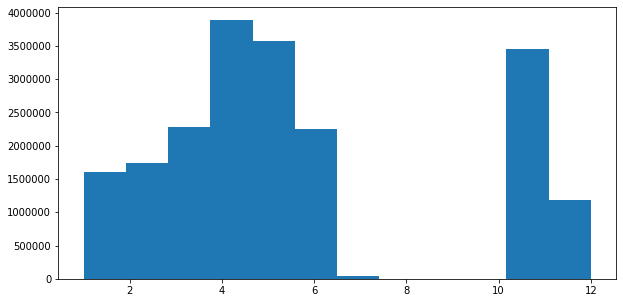

In [24]:
# построим график - продажи по месяцам
x = data['month']
num_bins = 12
plt.figure(figsize=(10, 5))
plt.hist(x, num_bins)
plt.show()

# у нас есть данные по продажам с января по начало июля, а потом за ноябрь/декабрь (часть декабря)

### Самые популярные товары

In [25]:
top_products = data.groupby(['name']).size().reset_index(name='number').sort_values(by=['number'], ascending=False)

In [26]:
top_products.head(10)

,name,number
26684,(48791) Свободная сумма НДС18% (служебный),169191
18206,(197312) Пакет-майка 25см х 45см,118106
13866,(181542) Карта Забота о Здоровье,89851
27955,(57733) Корвалол капли д/приема внутрь 25мл,87792
8107,(117825) Панангин таб.п.п.о.№50,77153
33270,(81509) PL Хлоргексидин биглюконат р-р 0.05% ф...,73543
19371,(20116) Тауфон капли глазн 4% фл 10 мл. пласт....,69044
31327,(70458) Пенталгин таб.п.п.о.№24 (без кодеина),68622
8255,(118125) Кардиомагнил таб.п.п.о.75мг №100,67034
13578,(180739) Омепразол-Акрихин капс.кишечнораст.20...,66781


### Количество покупок

In [30]:
# посчитаем количество транзакций для каждого покупателя за весь рассматриваемый период

In [31]:
purchase_frequency = data.groupby(['contact_id'])['sale_date'].nunique().reset_index(name='frequency')

In [32]:
purchase_frequency.head()

,contact_id,frequency
0,373,2
1,374,1
2,376,1
3,377,1
4,378,3


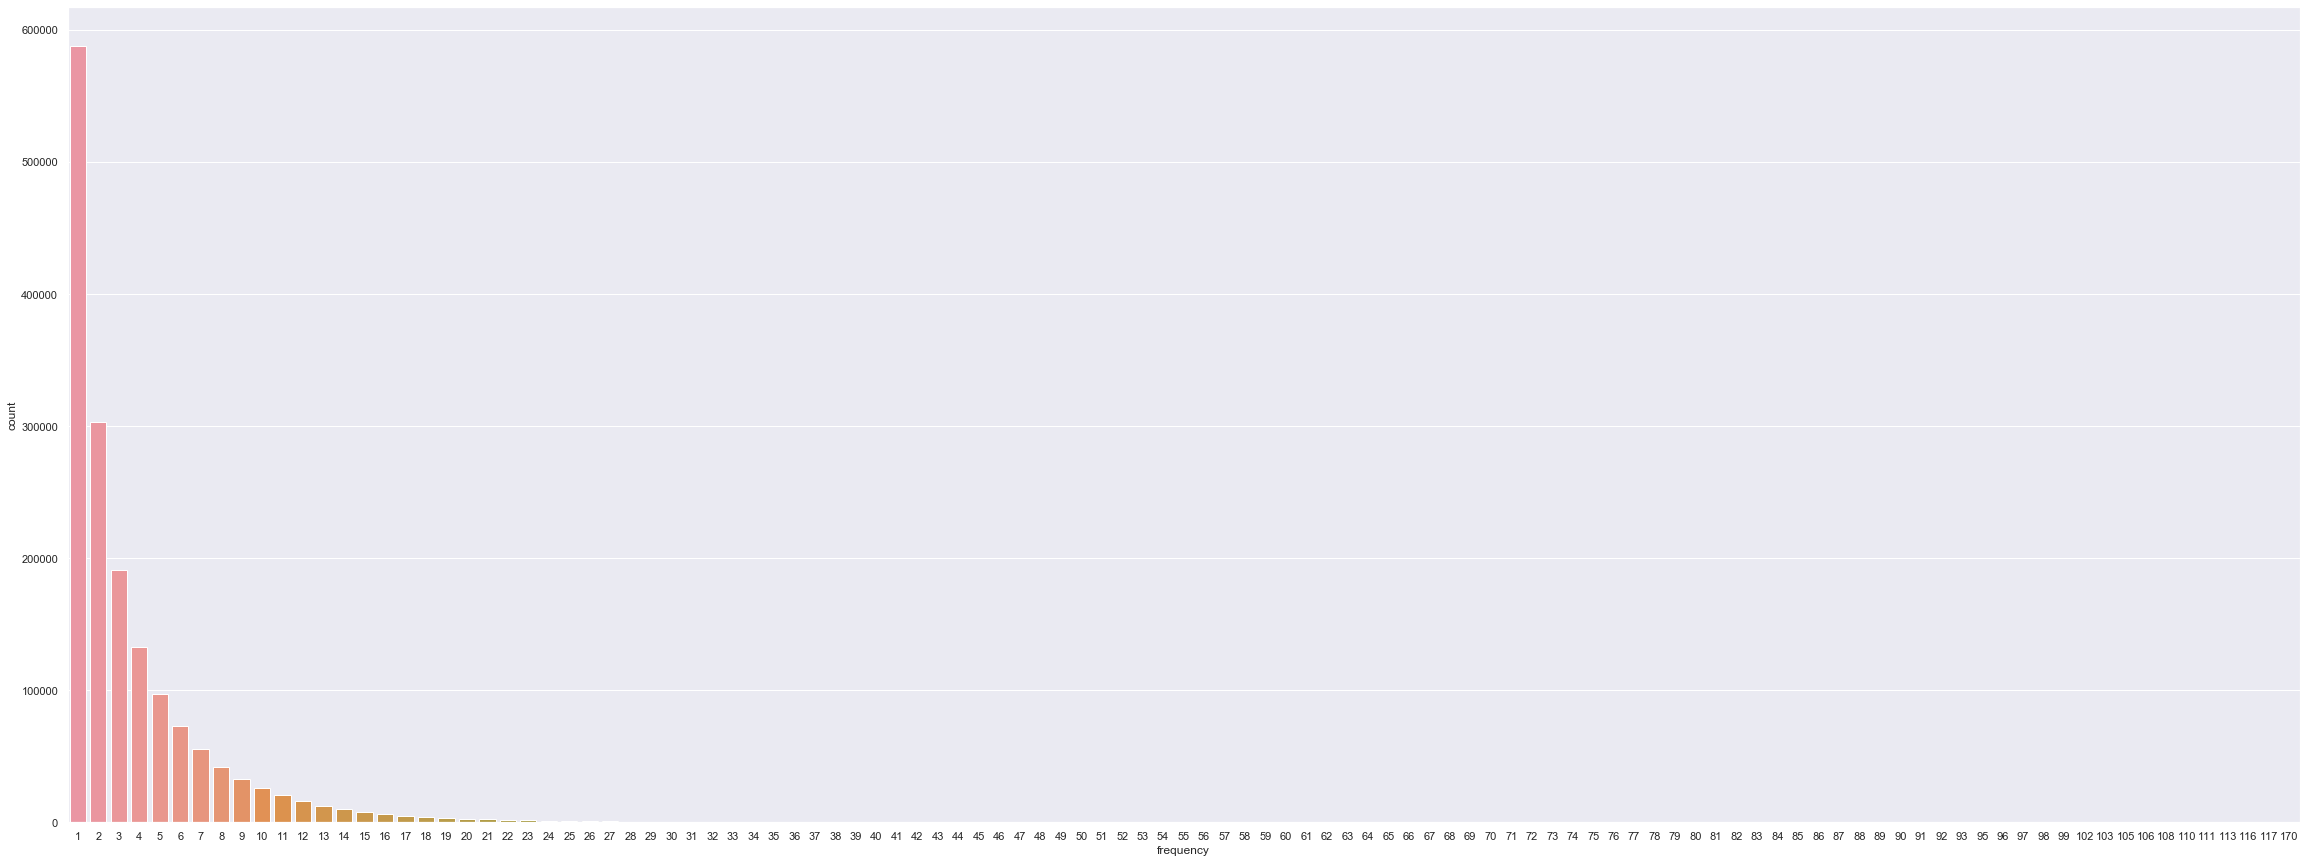

In [33]:
sns.set(rc = {'figure.figsize':(40, 15)})
sns.countplot(x='frequency', data=purchase_frequency)
plt.show()

In [34]:
# большинство покупателей совершило только одну покупку
# возможно, это объясняется тем, что у очень маленького процента покупателей есть карта лояльности

In [35]:
# 50% покупателей совершили 1 или 2 покупки
np.percentile(purchase_frequency['frequency'], [25, 50, 75])

array([1., 2., 5.])

In [36]:
np.percentile(purchase_frequency['frequency'], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

array([  1.,   1.,   1.,   2.,   2.,   3.,   4.,   6.,   8., 170.])

### Длина чека

In [37]:
bills = data.groupby(['contact_id', 'sale_date', 'shop_id'])['product_id'].unique().reset_index(name = 'products')
bills.head()

,contact_id,sale_date,shop_id,products
0,373,2018-02-21,311,"[113441, 137357, 115823, 158586, 91063, 61115,..."
1,373,2018-11-29,311,"[134832, 19578, 57835, 154101, 61115]"
2,374,2018-12-07,608,[38462]
3,376,2018-01-22,271,[105098]
4,377,2018-01-02,268,"[44789, 62807, 102048]"


In [38]:
bills = bills['products'].tolist()
bills[0]

array([113441, 137357, 115823, 158586,  91063,  61115, 147658])

In [39]:
# получили список, состоящий из numpy arrays
# преобразуем в список списков

bills_list = []

for element in bills:
    bills_list.append(element.tolist())
    
bills_list[0]

[113441, 137357, 115823, 158586, 91063, 61115, 147658]

In [40]:
bills_length = [len(x) for x in bills_list]

In [159]:
np.percentile(bills_length, [0, 25, 50, 75, 100])

array([  1.,   1.,   2.,   4., 342.])

In [41]:
min_bill_length = min(bills_length)
mean_bill_length = mean(bills_length)
median_bill_length = median(bills_length)
max_bill_length = max(bills_length)

print('# min bill length: ', min_bill_length)
print('# mean bill length: ', mean_bill_length)
print('# median bill length: ', median_bill_length)
print('# max bill length: ', max_bill_length)

# min bill length:  1
# mean bill length:  3.190220173213312
# median bill length:  2
# max bill length:  342


### Количество транзакций с 2-мя и более товарами

In [131]:
# возьмем транзакции с 2-мя и более товарами (для работы алгоритма Word2Vec)

bill_length_2_and_more = []

for element in bills_list:
    if len(element) >= 2:
        bill_length_2_and_more.append(element)

In [132]:
len(bill_length_2_and_more)

4421405

In [133]:
# процент транзакций с 2-мя и более товарами
len(bill_length_2_and_more) / len(bills_list) * 100

72.19107182247554

## Разбиение данных на тренировочную и тестовую выборки

In [42]:
data_train = data.loc[data['month'] < 6]

In [43]:
data_train.month.unique()

array([1, 2, 3, 4, 5])

In [44]:
data_train.shape

(13085180, 10)

In [45]:
data_test = data.loc[(data['month'] >= 6) & (data['month'] < 8)]

In [46]:
data_test.month.unique()

array([6, 7])

In [47]:
data_test.shape

(2289678, 10)

## Обучение модели

In [49]:
# создадим список с историей покупок на тренировочном датасете

bills_train = data_train.groupby(['contact_id', 'sale_date', 'shop_id'])['product_id'].unique().reset_index(name = 'products')
bills_train.head()

,contact_id,sale_date,shop_id,products
0,373,2018-02-21,311,"[113441, 137357, 115823, 158586, 91063, 61115,..."
1,376,2018-01-22,271,[105098]
2,377,2018-01-02,268,"[44789, 62807, 102048]"
3,378,2018-03-22,269,"[75972, 83462, 41353]"
4,378,2018-04-25,97,"[75972, 41353, 114112, 101409, 69416]"


In [50]:
bills_train_list = bills_train['products'].tolist()
bills_train_list[0]

array([113441, 137357, 115823, 158586,  91063,  61115, 147658])

In [51]:
# получили список, состоящий из numpy arrays
# преобразуем в список списков

bills_train = []

for element in bills_train_list:
    bills_train.append(element.tolist())
    
bills_train[0]

[113441, 137357, 115823, 158586, 91063, 61115, 147658]

In [54]:
len(bills_train)

3822386

In [68]:
# возьмем транзакции с 3-мя и более товарами

bills_train_model = []

for element in bills_train:
    if len(element) >= 3:
        bills_train_model.append(element)

In [69]:
len(bills_train_model)

1907662

In [70]:
# процент транзакций с 3-мя и более товарами
len(bills_train_model) / len(bills_train) * 100

49.90762314428736

In [71]:
# проверим среднюю длину чека после того, как отобрали только транзакции с 3-мя и более продуктами.

bills_train_length = [len(x) for x in bills_train_model]

In [72]:
min_bill_length_train = min(bills_train_length)
mean_bill_length_train = mean(bills_train_length)
median_bill_length_train = median(bills_train_length)
max_bill_length_train = max(bills_train_length)

print('# min bill length: ', min_bill_length_train)
print('# mean bill length: ', mean_bill_length_train)
print('# median bill length: ', median_bill_length_train)
print('# max bill length: ', max_bill_length_train)

# min bill length:  3
# mean bill length:  5.213378470609573
# median bill length:  4.0
# max bill length:  342


In [73]:
# обучаем Word2Vec модель

model = Word2Vec(bills_train_model, vector_size = 350, window = 10, sg = 0, min_count = 5)

## Проверяем работу модели на тестовой выборке

### Создаем датафрейм с историей покупок

In [74]:
# создаем датафрейм с историей покупок на тестовом датасете

test_df = pd.DataFrame()

# В датафрейм добавим следующие столбцы:
# basket - 2/3 товаров корзины, которые передаем модели
# targets - 1/3 товаров корзины, которые пытаемся предсказать
# recs - рекомендованные моделью товары

In [75]:
bills_test = data_test.groupby(['contact_id', 'sale_date', 'shop_id'])['product_id'].unique().reset_index(name = 'products')
bills_test.head()

,contact_id,sale_date,shop_id,products
0,384,2018-06-06,321,"[40261, 21168]"
1,390,2018-06-05,348,"[51657, 121659, 147598]"
2,397,2018-06-08,311,"[128727, 18309]"
3,398,2018-06-06,1057,[64787]
4,398,2018-06-10,1057,"[68751, 64731, 64787]"


In [76]:
bills_test_list = bills_test['products'].tolist()
bills_test_list[0]

array([40261, 21168])

In [77]:
# получили список, состоящий из numpy arrays
# преобразуем в список списков

bills_test = []

for element in bills_test_list:
    bills_test.append(element.tolist())
    
bills_test[0]

[40261, 21168]

In [78]:
len(bills_test)

750009

In [79]:
# возьмем транзакции с 3-мя и более товарами

bills_test_model = []

for element in bills_test:
    if len(element) >= 3:
        bills_test_model.append(element)

In [80]:
len(bills_test_model)

326162

In [81]:
# процент транзакций с 3-мя и более товарами
len(bills_test_model) / len(bills_test) * 100

43.4877448137289

In [83]:
# проверим среднюю длину чека после того, как отобрали только транзакции с 3-мя и более продуктами.

bills_test_length = [len(x) for x in bills_test_model]

In [85]:
min_bill_length_test = min(bills_test_length)
mean_bill_length_test = mean(bills_test_length)
median_bill_length_test = median(bills_test_length)
max_bill_length_test = max(bills_test_length)

print('# min bill length: ', min_bill_length_test)
print('# mean bill length: ', mean_bill_length_test)
print('# median bill length: ', median_bill_length_test)
print('# max bill length: ', max_bill_length_test)

# min bill length:  3
# mean bill length:  5.025318706654975
# median bill length:  4.0
# max bill length:  261


In [91]:
# basket - 2/3 товаров корзины

basket_test = []

for element in bills_test_model:
    lenth = round((len(element) / 3) * 2)
    basket_products = element[:lenth]
    basket_test.append(basket_products)

In [92]:
# targets - 1/3 товаров корзины

targets_test = []

for element in bills_test_model:
    lenth = round((len(element) / 3) * 2)
    target_products = element[lenth:]
    targets_test.append(target_products)

In [93]:
test_df['basket'] = basket_test
test_df['targets'] = targets_test

test_df.head()

,basket,targets
0,"[51657, 121659]",[147598]
1,"[68751, 64731]",[64787]
2,"[153158, 48367]",[66646]
3,"[155974, 145864, 51564]","[93274, 76935]"
4,"[135553, 120687]",[123293]


### Получаем предсказания модели

In [94]:
def model_predict(basket, n):
    
    recs = model.predict_output_word(basket, topn=n)
    
    result = []
    
    if recs is None:
        pass
    else:
        for rec in recs:
            result.append(rec[0])
    
    return result  

In [95]:
# Предсказываем 5 товаров.
# Из этих 5-ти товаров фармацевт выбирает те, которые:
    # отпускаются без рецепта врача;
    # наиболее удачно соотçветствуют запросу клиента.

In [97]:
test_df['recs'] = test_df['basket'].apply(lambda x: model_predict(x, n=5))

In [98]:
test_df.head()

,basket,targets,recs
0,"[51657, 121659]",[147598],"[61101, 100313, 72324, 133589, 61087]"
1,"[68751, 64731]",[64787],"[79960, 95179, 118235, 90696, 94613]"
2,"[153158, 48367]",[66646],"[153160, 153393, 153446, 153158, 154019]"
3,"[155974, 145864, 51564]","[93274, 76935]","[125415, 192043, 145899, 68690, 61946]"
4,"[135553, 120687]",[123293],"[148082, 135553, 41096, 56592, 42350]"


### Проверяем качество и считаем recall at 5

In [105]:
def flags(recommended_list, bought_list):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    flags = flags.sum()
    
    return flags

In [106]:
test_df['flags'] = test_df.apply(lambda row: flags(row['recs'], row['targets']), axis=1)

In [143]:
test_df['targets_length'] = test_df.apply(lambda row: len(row['targets']), axis=1)

In [160]:
test_df.head()

,basket,targets,recs,flags,targets_length
0,"[51657, 121659]",[147598],"[61101, 100313, 72324, 133589, 61087]",0,1
1,"[68751, 64731]",[64787],"[79960, 95179, 118235, 90696, 94613]",0,1
2,"[153158, 48367]",[66646],"[153160, 153393, 153446, 153158, 154019]",0,1
3,"[155974, 145864, 51564]","[93274, 76935]","[125415, 192043, 145899, 68690, 61946]",0,2
4,"[135553, 120687]",[123293],"[148082, 135553, 41096, 56592, 42350]",0,1


In [145]:
test_df['targets_length'].sum()

533620

In [153]:
test_df['flags'].sum()

22308

In [158]:
# посчитаем соотношение правильно предсказанных моделью товаров к общему числу транзакций

22308 / 326162

0.06839545992482264

In [156]:
# посчитаем recall at 5

recall_at_5 = 22308 / 533620 * 100

In [157]:
recall_at_5

4.180502979648439

### считаем hit rate at k

In [112]:
def hit_rate_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    hit_rate_at_k = (flags.sum() > 0) * 1
    
    return hit_rate_at_k

In [113]:
test_df.apply(lambda row: hit_rate_at_k(row['recs'], row['targets']), axis=1).mean()

0.0664301788681698